In [2]:
from torchvision.datasets.utils import download_url
import json
# Download class labels from imagenet dataset
download_url("https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json", ".", "imagenet_class_index.json")

with open("imagenet_class_index.json", "r") as h:
    labels = json.load(h)

Using downloaded and verified file: ./imagenet_class_index.json


In [3]:
import torch
from torch.utils import data
from torchvision.models import vgg16
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np


transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# initialize the model
model = vgg16(pretrained=True)

# set the evaluation mode
model.eval()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [21]:
# get the image from the dataloader
dataset = datasets.ImageFolder(root='./data/', transform=transform)
dataloader = data.DataLoader(dataset=dataset, shuffle=False )#batch_size=1
img, _ = next(iter(dataloader))

In [144]:
# get prediction of the model
pred = model(img)#.argmax(dim=1)
#pred_sorted = torch.sort(pred, descending=True)
#print(pred_sorted)

# numpy transformation
tensor_array = pred.detach().cpu().numpy()
tensor_array = np.squeeze(tensor_array)
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

tensor_array_sorted = np.sort(tensor_array)[::-1]
tensor_array_sorted = tensor_array_sorted[0:5]
print(tensor_array_sorted)

ind = np.argsort(tensor_array)[::-1][0:5]
print(ind)

#print(tensor_array)

# extract top elements
#print(torch.topk(pred, 5, dim=1, largest=True, sorted=True, out=None))



[23.179834 22.035618 21.604549 20.495251 19.967808]
[353 350 349 352 348]


In [170]:
import re
#print(pred.argmax(dim=1))
with open("imagenet_class_index.json", "r") as h:
    labels = json.load(h)

y = np.array([])
for i in range(0,5):
    str_label = str(ind[i])
    y = np.append(y, labels[str_label][1])
    print(tensor_array_sorted[i], labels[str_label][1])

print(y)

23.179834 gazelle
22.035618 ibex
21.60455 bighorn
20.49525 impala
19.967808 ram
['gazelle' 'ibex' 'bighorn' 'impala' 'ram']


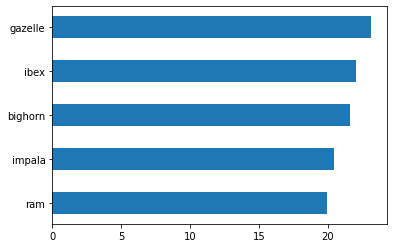

In [175]:
import matplotlib.pyplot as plt
import numpy as np

plt.barh(y[::-1], tensor_array_sorted[::-1], height = 0.5)
plt.show()

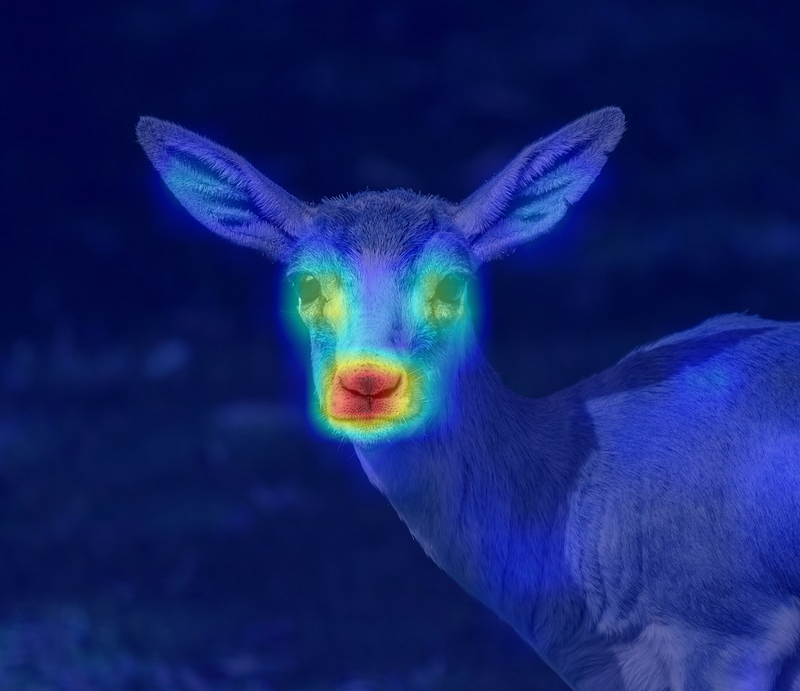

In [152]:
from pytorch_grad_cam import GradCAM
import cv2
from PIL import Image
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
img = np.asarray(cv2.imread('./data/Shark/gazelle.jpg'))

img = np.squeeze(img)
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

img = np.float32(img)/255
input_tensor = preprocess_image(img,
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
target_layers = [model.features[-1]]

cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False) # use_cuda=args.use_cuda
grayscale_cam = cam(input_tensor=input_tensor, targets=None, aug_smooth=True, eigen_smooth=True )[0, :]
visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True, colormap = cv2.COLORMAP_JET) #
Image.fromarray(visualization)